<a id="top"></a>
# Conclusion
The model found under [4.9](#4_9) got the highest **adjusted R²** of **0.8107** with the respective adjustments made.<br>
Please follow the [cleaning process](#read_clean) and find the code snippet for the adjusted DataFrame und [4.9](#4_9).<br>
The process of adjusting can be found from [4. Findings](#findings) onward.<br>

For further models with different adjustments of the DataFrame jump to [3.1 DataFrame set up](#df_setup) and apply the changes to<br> **ca_df_adj** and choose options for things to display, run the code and find the metrics under [3.2 Result Output](#result).

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

## 1 Functions

In [2]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

In [3]:
def plot_hist_normalized(this_column, this_scaler: [str] = "standard_scaler"):
    if this_scaler == "power_transformator":
        pt = PowerTransformer()
        col_transformed_pt=pt.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_pt).set(title=f"{this_column.name} - PowerTransformer") 
    elif this_scaler == "quantile_transformer":
        qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
        col_transformed_qt=qt.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_qt).set(title=f"{this_column.name} - QuantileTransformer")
    else:
        sc = StandardScaler()
        col_transformed_sc=sc.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_sc).set(title=f"{this_column.name} - StandardScaler")

In [4]:
def boxplots_for_all_numerical_cols(this_df):
    fig, ax = plt.subplots(figsize=(10,10))
    len_num_lst = len(split_column_names_by(this_df)[0])
    i = 1
    for col in split_column_names_by(this_df)[0]:            
        plt.subplot(math.ceil(len_num_lst**.5),math.ceil(len_num_lst**.5),i)
        sns.boxplot(y=this_df[col]).set(title=f"{col}")
        i += 1

In [5]:
def split_df_by(this_df, include_dtypes:[list]=["int","float"]):
    """takes in this_df, splits it into two NEW DF's by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_df, excl_df)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (this_df[incl_lst], this_df[excl_lst])

In [6]:
def all_numeric_to_int(this_df):
    for col in this_df._get_numeric_data():
        this_df[col] = this_df[col].astype(np.int64)
    return this_df

In [7]:
def all_strings_lowercase(this_df):
    for col in this_df:
        this_df[col] = this_df[col].map(lambda x: x.lower() if isinstance(x,str) else x)
    return this_df

In [8]:
def nan_values_of_all_columns(this_df, return_dict:[bool] = False):
    """prints (defaults) or returns dictionary of all columns in this_df and their respective nan-values"""
    if not return_dict:
        for col in this_df.columns:
            print(col, this_df[col].isna().sum())
        return
    return {col:this_df[col].isna().sum() for col in this_df.columns}

<a id='read_clean'></a>

## 2 Read and Clean

In [9]:
ca_df = pd.read_csv("C:/Users/roman/Documents/GitHub/Customer_Data_Analysis/Data/marketing_cust_analysis_round2.csv")
# ca_df.columns

### 2.1 Numerical columns

#### 2.1.1 Boxplots

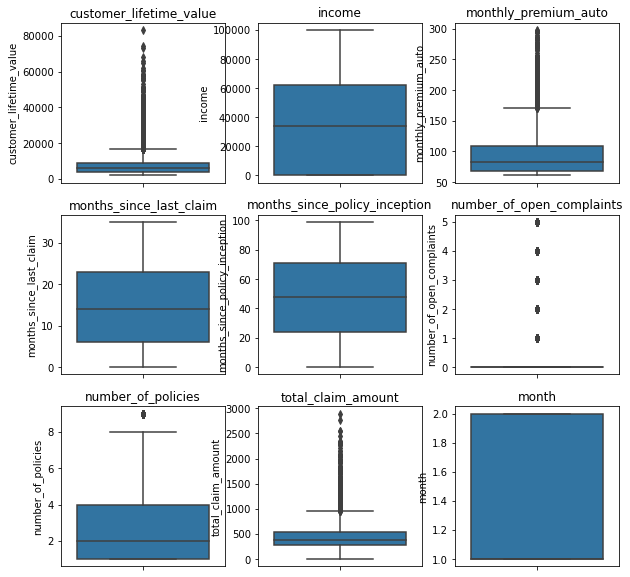

In [10]:
boxplots_for_all_numerical_cols(ca_df)

#### 2.1.2 Check for NaNs

In [11]:
nan_values_of_all_columns(ca_df[split_column_names_by(ca_df)[0]])

customer_lifetime_value 0
income 0
monthly_premium_auto 0
months_since_last_claim 633
months_since_policy_inception 0
number_of_open_complaints 633
number_of_policies 0
total_claim_amount 0
month 0


In [12]:
ca_df["months_since_last_claim"].value_counts()

3.0     426
6.0     394
1.0     386
7.0     378
4.0     373
2.0     368
5.0     355
0.0     354
10.0    346
16.0    333
11.0    331
15.0    323
13.0    320
8.0     315
12.0    307
17.0    299
14.0    299
9.0     277
23.0    276
19.0    276
25.0    269
21.0    267
18.0    257
20.0    254
22.0    246
24.0    237
29.0    234
28.0    227
31.0    221
26.0    211
27.0    208
30.0    201
34.0    199
33.0    198
35.0    157
32.0    155
Name: months_since_last_claim, dtype: int64

NaN will be replaced with mean of months_since_last_claim

In [13]:
ca_df["months_since_last_claim"].fillna(np.mean(ca_df["months_since_last_claim"]), inplace=True)

#### 2.1.3 Change appropriate numerical columns to categorical

In [14]:
for col in ["number_of_open_complaints","number_of_policies", "month"]:
    ca_df[col] = ca_df[col].astype('category')

#### 2.1.4 Change all numeric values to integer

In [15]:
ca_df = all_numeric_to_int(ca_df)

### 2.2 Categorical columns

#### 2.2.1 Check for NaNs

In [16]:
nan_values_of_all_columns(ca_df[split_column_names_by(ca_df)[1]])

customer 0
state 631
response 631
coverage 0
education 0
effective_to_date 0
employmentstatus 0
gender 0
location_code 0
marital_status 0
number_of_open_complaints 633
number_of_policies 0
policy_type 0
policy 0
renew_offer_type 0
sales_channel 0
vehicle_class 622
vehicle_size 622
vehicle_type 5482
month 0


A NaN value in the *response* will be considered as a **No**.

In [17]:
ca_df["response"].fillna("No", inplace=True)

In [18]:
ca_df["number_of_open_complaints"].value_counts()

0.0    8160
1.0    1145
2.0     414
3.0     324
4.0     166
5.0      68
Name: number_of_open_complaints, dtype: int64

A majority of *number_of_open_complaints* is 0, therefore the NaN values will be replaced with 0.

In [19]:
ca_df["number_of_open_complaints"].fillna(0, inplace=True)

#### 2.2.2 Drop some columns
+ customer → kind of primary key
+ effective_to_date → does not seem to have an effect for the model
+ vehicle_type → approximately 50% datapoints have missing values

In [20]:
ca_df.drop(["customer", "effective_to_date", "vehicle_type"], axis=1, inplace=True)

#### 2.2.3 All strings to lower case

In [21]:
ca_df = all_strings_lowercase(ca_df)

[top of notebook](#top)

## 3. Adjust the DataFrame to fine tune the model

<a id="df_setup"></a>
### 3.1 Dataframe set up
Create a copy of the cleaned DataFrame to avoid multiple new runs of the cleaning process

In [22]:
ca_df_adj = ca_df

**In the follwoing cell, adjust the DataFrame**

In [23]:
from scipy import stats
ca_df_adj = ca_df_adj[ca_df_adj["income"] != 0]
ca_df_adj = ca_df_adj[(np.abs(stats.zscore(ca_df_adj['customer_lifetime_value']))<3)]

Select scaling method by (un)commenting contents of the following cell:

In [24]:
scaler = "standard_scaler"
# scaler = "quantile_transformer"
# scaler = "power_transformator"  # not completely tested


Select further options:

In [25]:
show_boxplots_for_all_numerical = True
show_histograms_for_normalized_cols = False
show_hist_for_X = False
print_model_data = False
show_prediction_plots = True

When complete, run code and find the result under [output](#result).

#### 3.1.1 Numerical

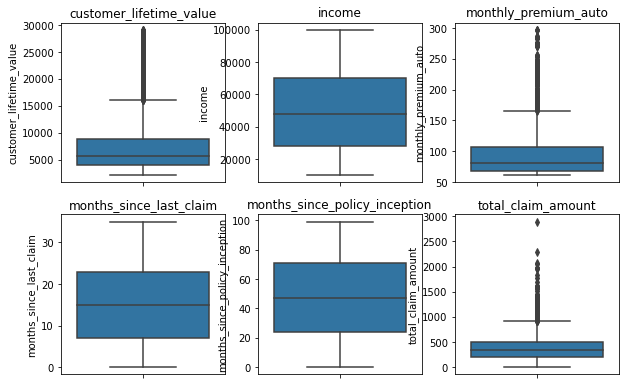

In [26]:
if show_boxplots_for_all_numerical:
    boxplots_for_all_numerical_cols(split_df_by(ca_df_adj)[0])

In [27]:
if show_histograms_for_normalized_cols:
    for col in split_column_names_by(ca_df_adj)[0]:
        plot_hist_normalized(ca_df_adj[col], scaler)

#### 3.1.2 Categorical

In [28]:
categoricals_features= ca_df_adj.select_dtypes("object")

In [29]:
cat_cols=pd.get_dummies(categoricals_features, drop_first=True)

#### 3.1.3 X-y split

In [30]:
X=ca_df_adj.drop("total_claim_amount", axis=1)
y=ca_df_adj["total_claim_amount"]

In [31]:
X=X._get_numeric_data()
# X

In [32]:
if show_hist_for_X:
    X.hist(figsize=(14,14))

**Concat dummies to numeric standardized**

In [33]:
X = pd.concat([X,cat_cols],axis=1)
# X

#### 3.1.4 Data splitting

In [34]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=42)

#### 3.1.5 Standardize
+ Build scaling parameters on training set (mean variance) → more data as approx 80 % of sample <br>



In [35]:
if scaler == "quantile_transformer":
    scaler_used = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(X_train)
elif scaler == "power_transformator":
    scaler_used = PowerTransformer().fit(X_train)
else:
    scaler_used = StandardScaler().fit(X_train)

+ Apply on training set

In [36]:
X_train_scaled=scaler_used.transform(X_train)

+ as well as on test set (same std_scaler but generated by a bigger set of values), same scaling param's as x_train

In [37]:
X_test_scaled=scaler_used.transform(X_test)

#### 3.1.6 Modeling using Statsmodels

In [38]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
if print_model_data:
    print(print_model)

In [39]:
predictions_test

array([414.73237508, 387.76651546, 449.97785651, ..., 547.08020752,
       595.3764829 , 411.65639211])

#### 3.1.7 Modeling using Scikit Learn

##### 3.1.7.1 Model fitting

In [40]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### 3.1.7.2 Parameters of model

In [41]:
model.coef_

array([ 2.52629083e+00, -7.86751753e+00,  1.56403601e+02,  1.08817931e-01,
       -6.85943931e-01,  9.42977540e-02, -2.22169059e+00,  2.57666658e-02,
        1.46295787e+00, -3.96170597e-01, -5.91668657e+00, -5.84889201e+00,
       -1.99933803e+00, -2.31035956e+00,  1.20964619e-01, -1.42955072e-01,
       -1.38943827e+00,  5.16986720e+00, -2.29253310e+00,  4.25429943e+00,
        1.85479044e+02,  9.08838962e+01, -4.93516109e+00, -6.68938140e-01,
        7.53474171e+13, -1.50812627e+14, -2.66711129e+00,  3.50673747e-02,
       -5.81651586e+13, -7.28392852e+13, -8.31654631e+13,  7.14966435e+13,
        9.71264347e+13,  9.39927305e+13,  6.01456110e+00,  2.59259180e+00,
        2.26919564e+00, -6.62591663e-01, -1.20033253e+00,  1.83680494e+00,
       -4.77876959e+00, -6.24705148e+00, -9.24438466e+00, -1.11039170e+01,
        1.59723377e+00,  8.65605554e-01,  3.44717017e+00])

In [42]:
model.intercept_

372.36741522343266

In [43]:
model.score(X_test_scaled,y_test)

0.8144529403355216

##### 3.1.7.3 Making prediction

In [44]:
y_pred=model.predict(X_test_scaled)

In [45]:
# y_test

In [46]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### 3.1.7.4 Plots

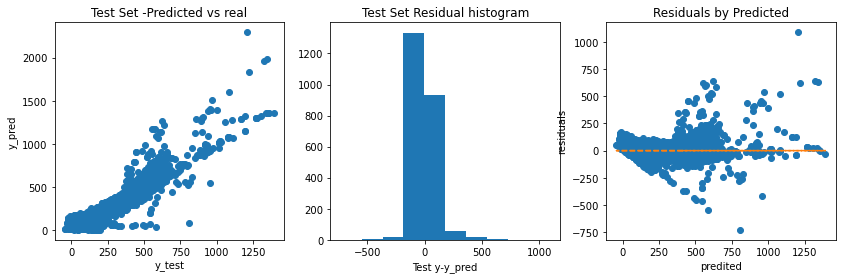

In [47]:
if show_prediction_plots:
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].plot(y_pred, y_test, 'o')
    ax[0].set_xlabel("y_test")
    ax[0].set_ylabel("y_pred")
    ax[0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1].hist(y_test - y_pred)
    ax[1].set_xlabel("Test y-y_pred")
    ax[1].set_title("Test Set Residual histogram")

    ax[2].plot(y_pred,y_test - y_pred,"o")
    ax[2].set_xlabel("predited")
    ax[2].set_ylabel("residuals")
    ax[2].set_title("Residuals by Predicted")
    ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

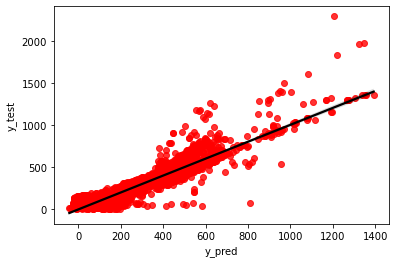

In [48]:
if show_prediction_plots:
    sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

##### 3.1.7.5 Error metrics Test

In [49]:
mse_test = mse(y_test,y_pred)
mae_test = mae(y_test,y_pred)

In [50]:
r2_test=r2_score(y_test,y_pred)


In [51]:
adj_r2_test= 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)


##### 3.1.7.6 Error metrics Train

In [52]:
y_pred=model.predict(X_train_scaled)

In [53]:
mse_train = mse(y_train,y_pred)
mae_train = mae(y_train,y_pred)

In [54]:
r2_train=r2_score(y_train,y_pred)


In [55]:
adj_r2_train= 1 - (1-r2_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)


***

<a id ="result"> </a>
### 3.2 Result Output

In [56]:
print(f"Adjusted Dataset contains {round(len(ca_df_adj)/len(ca_df)*100,2)} % of original data points ({len(ca_df_adj)} out of {len(ca_df)}).")
print("")
print("Error Metrics Test Set:\n")
print("         MSE =", round(mse_test, 4),"\n")
print("         MAE =", round(mae_test, 4),"\n")
print("          R² =", round(r2_test, 4),"\n")
print(" Adjusted R² =", round(adj_r2_test, 4),"\n")
print("\n---\n")
print("Error Metrics Train Set:","\n")
print("         MSE =", round(mse_train, 4),"\n")
print("         MAE =", round(mae_train, 4),"\n")
print("          R² =", round(r2_train, 4),"\n")
print(" Adjusted R² =", round(adj_r2_train, 4),"\n")

Adjusted Dataset contains 72.67 % of original data points (7928 out of 10910).

Error Metrics Test Set:

         MSE = 11066.6637 

         MAE = 72.8891 

          R² = 0.8145 

 Adjusted R² = 0.8107 


---

Error Metrics Train Set: 

         MSE = 11728.5444 

         MAE = 73.6531 

          R² = 0.8023 

 Adjusted R² = 0.8006 



Change DataFrame [set up](#df_setup) here.

[top of notebook](#top)

<a id='findings'> </a>
## 4. Findings


### 4.1 No further adjustments (StandardScaler)

Adjusted Dataset contains 100.0 % of original data points (10910 out of 10910).

Error Metrics Test Set:

         MSE = 18652.2074 

         MAE = 94.935 

          R² = 0.7746 

 Adjusted R² = 0.7712 


---

Error Metrics Train Set: 

         MSE = 19987.9543 

         MAE = 96.1992 

          R² = 0.7689 

 Adjusted R² = 0.7675 


### 4.2 No further adjustments (QuantileTransformer)

Adjusted Dataset contains 100.0 % of original data points (10910 out of 10910).

Error Metrics Test Set:

         MSE = 21153.7264 

         MAE = 100.4403 

          R² = 0.7443 

 Adjusted R² = 0.7405 


---

Error Metrics Train Set: 

         MSE = 22458.368 

         MAE = 101.4327 

          R² = 0.7404 

 Adjusted R² = 0.7387 

### 4.3 No further adjustments (PowerTransformer)

Adjusted Dataset contains 100.0 % of original data points (10910 out of 10910).

Error Metrics Test Set:

         MSE = 20565.8156 

         MAE = 99.1895 

          R² = 0.7515 

 Adjusted R² = 0.7478 


---

Error Metrics Train Set: 

         MSE = 22176.8949 

         MAE = 100.7029 

          R² = 0.7436 

 Adjusted R² = 0.742 

### 4.4 Drop all income 0 rows  (StandardScaler)

`ca_df_adj = ca_df_adj[ca_df_adj["income"] != 0]`

Adjusted Dataset contains 74.45 % of original data points (8123 out of 10910).

Error Metrics Test Set:

         MSE = 14300.1229 

         MAE = 77.1185 

          R² = 0.7945 

 Adjusted R² = 0.7904 


---

Error Metrics Train Set: 

         MSE = 11713.3668 

         MAE = 73.7083 

          R² = 0.8075 

 Adjusted R² = 0.8059 


### 4.5 Income 0 replaced with mean (StandardScaler)

`ca_df_adj["income"] = ca_df_adj['income'].replace(0, np.mean(ca_df_adj[ca_df["income"]))`


Adjusted Dataset contains 100.0 % of original data points (10910 out of 10910).

Error Metrics Test Set:

         MSE = 18652.2902 

         MAE = 94.9343 

          R² = 0.7746 

 Adjusted R² = 0.7712 


---

Error Metrics Train Set: 

         MSE = 19987.9426 

         MAE = 96.199 

          R² = 0.7689 

 Adjusted R² = 0.7675 

### 4.6 Income 0 replaced with mean (excluding the 0's for the calculation of the mean)  (StandardScaler)

`ca_df_adj["income"] = ca_df_adj['income'].replace(0, np.mean(ca_df_adj[ca_df["income"] != 0]["income"]))`


Adjusted Dataset contains 100.0 % of original data points (10910 out of 10910).

Error Metrics Test Set:

         MSE = 18652.2902 

         MAE = 94.9343 

          R² = 0.7746 

 Adjusted R² = 0.7712 


---

Error Metrics Train Set: 

         MSE = 19987.9426 

         MAE = 96.199 

          R² = 0.7689 

 Adjusted R² = 0.7675 

### 4.7 Removing outliers from all numerical columns (StandardScaler)

`from scipy import stats
 ca_df_adj = ca_df_adj[(np.abs(stats.zscore(ca_df_adj.select_dtypes(include=np.number))) < 3).all(axis=1)]`


Adjusted Dataset contains 89.68 % of original data points (9784 out of 10910).

Error Metrics Test Set:

         MSE = 10985.1932 

         MAE = 78.0492 

          R² = 0.77 

 Adjusted R² = 0.7664 


---

Error Metrics Train Set: 

         MSE = 10041.3318 

         MAE = 75.7572 

          R² = 0.7736 

 Adjusted R² = 0.7721

### 4.8 Removing rows with outliers only from cust_lifetime_value (StandardScaler)
`
from scipy import stats
ca_df_adj = ca_df_adj[(np.abs(stats.zscore(ca_df_adj['customer_lifetime_value']))<3)]`

Adjusted Dataset contains 97.66 % of original data points (10655 out of 10910).

Error Metrics Test Set:

         MSE = 20450.4594 

         MAE = 95.8138 

          R² = 0.755 

 Adjusted R² = 0.7513 


---

Error Metrics Train Set: 

         MSE = 17973.5078 

         MAE = 93.2348 

          R² = 0.7777 

 Adjusted R² = 0.7762 

<a id='4_9'></a>
### 4.9 Removing rows with outliers only from cust_lifetime_value and dropping 0 income (StandardScaler)
`
from scipy import stats
ca_df_adj = ca_df_adj[ca_df_adj["income"] != 0]
ca_df_adj = ca_df_adj[(np.abs(stats.zscore(ca_df_adj['customer_lifetime_value']))<3)]`

Adjusted Dataset contains 72.67 % of original data points (7928 out of 10910).

Error Metrics Test Set:

         MSE = 11066.6637 

         MAE = 72.8891 

          R² = 0.8145 

 Adjusted R² = 0.8107 


---

Error Metrics Train Set: 

         MSE = 11728.5444 

         MAE = 73.6531 

          R² = 0.8023 

 Adjusted R² = 0.8006 

[top of notebook](#top)